In [205]:
import warnings
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import (
    model_built_data_paths,
    model_ready_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [206]:
asset_type = "building"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

# metric_key_unsmoothed = "weighted_median"
metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric

In [207]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_built_data_path = model_built_data_paths[dataset_name]

df = pd.read_csv(model_built_data_path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)


In [208]:
columns = [
    metric_pct_chg,
    metric,
    metric_unsmoothed,
    "year",
    "years_since_crisis",
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "total_tax",
    "total_tax_growth",
    "new_dwellings",
    "existing_dwellings",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "area_code",  # id
    "area", # additional info
]

<Axes: ylabel='Frequency'>

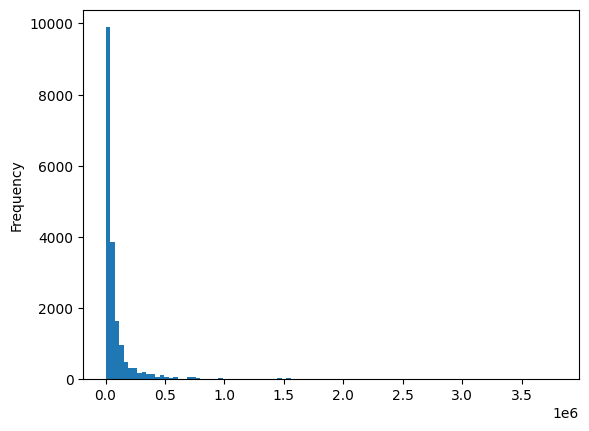

In [209]:
column = "population"
log_column = f"log_{column}"
df[column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

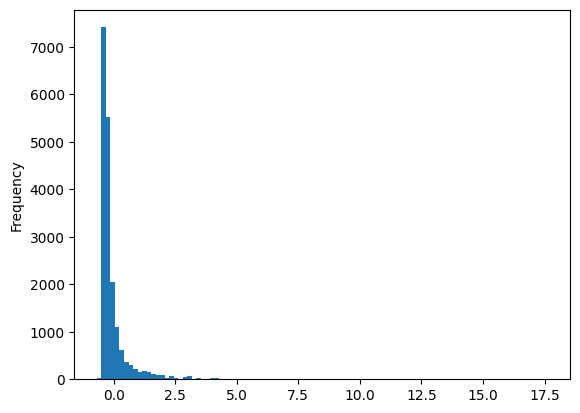

In [210]:
df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
    lambda x: (x - x.mean()) / x.std()
)
df[f"{column}_normalized_yearly"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

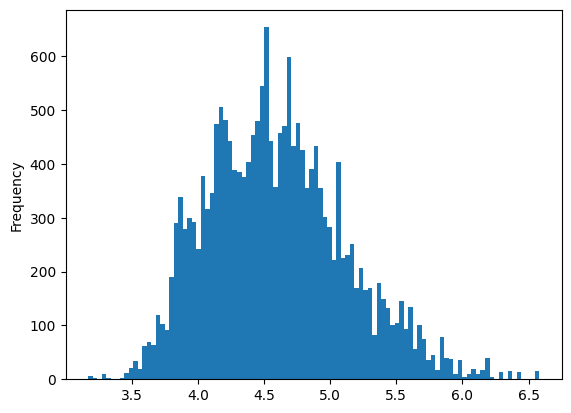

In [211]:
df[log_column] = df[column].apply(lambda x: np.log10(1 + x))
df[log_column].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

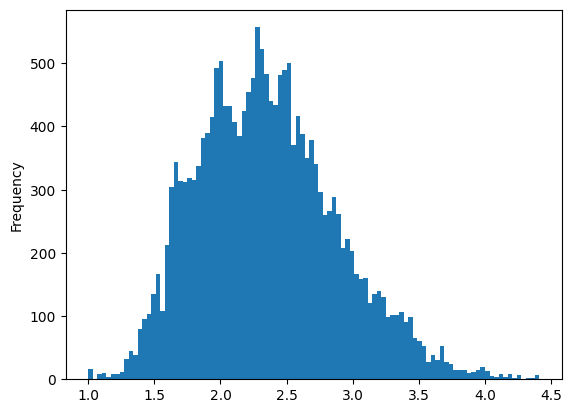

In [212]:
# df[f"{log_column}_normalized_yearly"] = df.groupby("year")[log_column].transform(
#     lambda x: (x - x.mean()) / x.std()
# )
df[f"{log_column}_normalized_yearly"] = df.groupby("year")[log_column].transform(
    lambda x: x - x.min() + 1
)
df[f"{log_column}_normalized_yearly"].plot.hist(bins=100)

In [213]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
]

# log_normalize_columns = []

# normalize_columns = [
#     metric,
#     metric_pct_chg,
#     "count",
#     "total_traded_area",
#     "population",
#     "taxpayer_count",
#     "taxable_income",
#     "taxable_income_per_taxpayer",
#     "taxable_income_growth",
#     "taxable_income_per_taxpayer_growth",
#     "new_dwellings",
#     "existing_dwellings",
#     "new_dwellings_ratio",
#     "net_migration_ratio",
#     "total_tax",
#     "total_tax_growth",
# ]

maintain_columns = [
    metric_pct_chg,
    # "years_since_crisis",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

id_columns = [
    "area_code",
    "area",
    "year",
]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [214]:
for column in log_normalize_columns:
    df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
    df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

for column in normalize_columns:
    df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
        lambda x: (x - x.mean()) / x.std()
    )

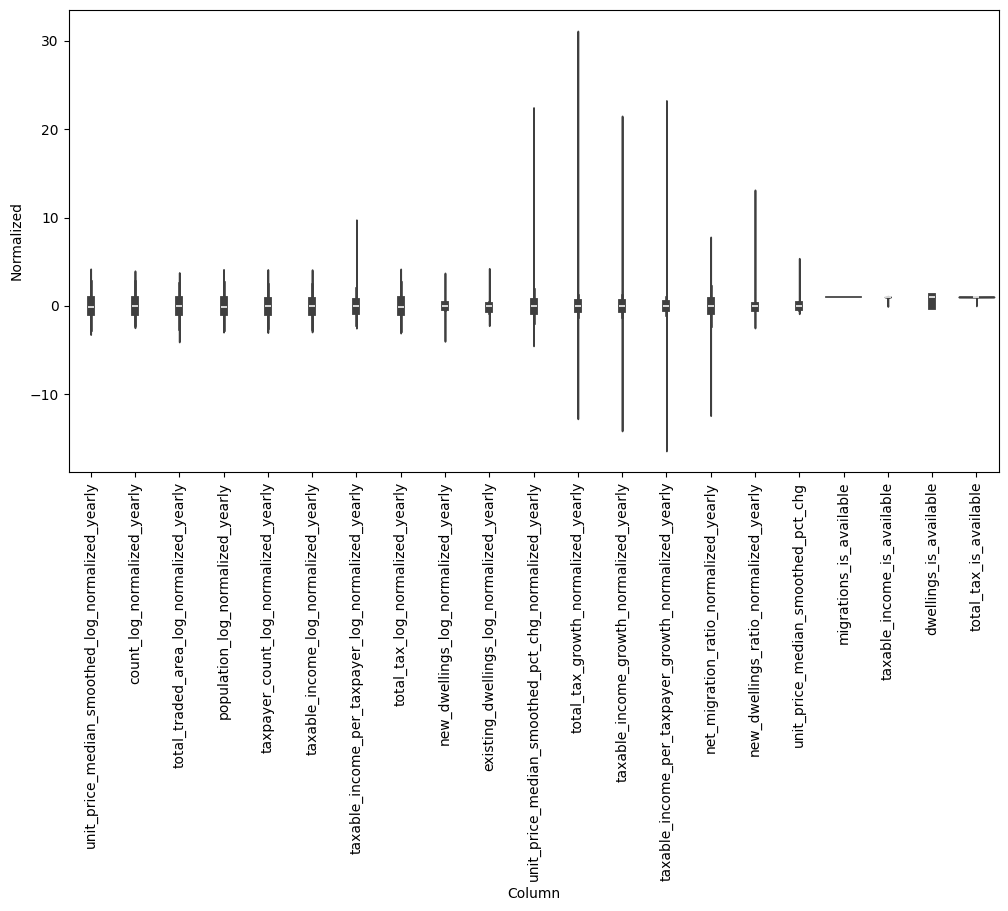

In [218]:
df_std = df[feature_columns].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[feature_columns].keys(), rotation=90)

In [216]:
df[final_columns].describe()

,area_code,year,unit_price_median_smoothed_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_pct_chg,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
count,18826.000000,18826.000000,1.882600e+04,1.882600e+04,1.882600e+04,1.882600e+04,1.741000e+04,1.741000e+04,1.741000e+04,1.879000e+04,1.037800e+04,1.037800e+04,1.882600e+04,1.877800e+04,1.741000e+04,1.741000e+04,1.882600e+04,1.037800e+04,18826.000000,18826.0,18826.000000,18826.000000,18826.000000
mean,21603.518963,2015.617125,-1.415349e-17,-2.189544e-16,-2.188129e-16,9.567756e-17,4.999511e-18,-2.754833e-16,2.063063e-16,2.628138e-16,-2.695859e-17,-1.692400e-16,-2.736341e-18,1.324369e-18,-1.086628e-17,2.458943e-17,8.775161e-18,-4.972361e-17,-0.002124,1.0,0.924785,0.551259,0.998088
std,13633.134424,3.973032,9.996015e-01,9.996015e-01,9.996015e-01,9.996015e-01,9.995978e-01,9.995978e-01,9.995978e-01,9.996008e-01,9.993252e-01,9.993252e-01,9.996015e-01,9.996005e-01,9.995978e-01,9.995978e-01,9.996015e-01,9.993252e-01,0.215441,0.0,0.263745,0.497379,0.043689
min,1100.000000,2007.000000,-2.985464e+00,-2.215086e+00,-3.823150e+00,-2.707537e+00,-2.770323e+00,-2.703549e+00,-2.268506e+00,-2.815473e+00,-3.823609e+00,-2.054150e+00,-4.265657e+00,-1.253148e+01,-1.391518e+01,-1.618057e+01,-1.217115e+01,-2.314005e+00,-0.846925,1.0,0.000000,0.000000,0.000000
25%,11100.000000,2012.000000,-7.441700e-01,-7.528959e-01,-6.534801e-01,-7.496825e-01,-7.504884e-01,-7.639827e-01,-6.760740e-01,-7.353618e-01,-7.024129e-01,-7.285002e-01,-5.477251e-01,-3.513131e-01,-3.508519e-01,-3.008739e-01,-5.855663e-01,-6.685586e-01,-0.118428,1.0,1.000000,0.000000,1.000000
50%,21202.500000,2016.000000,-9.518779e-02,-7.583123e-02,1.612768e-03,-8.707076e-02,-8.374803e-02,-9.416435e-02,-1.518786e-01,-9.111074e-02,-5.778841e-02,-1.984447e-01,-5.544731e-02,-5.026445e-02,-2.366536e-02,-2.932723e-02,-2.167807e-02,-8.987009e-02,-0.015540,1.0,1.000000,1.000000,1.000000
75%,32501.000000,2019.000000,6.987708e-01,6.913396e-01,6.461293e-01,6.158199e-01,6.304269e-01,6.413247e-01,4.974514e-01,6.590143e-01,6.184137e-01,5.593191e-01,4.155062e-01,2.769748e-01,3.159421e-01,2.526689e-01,5.353507e-01,4.916479e-01,0.087146,1.0,1.000000,1.000000,1.000000
max,47362.000000,2022.000000,3.905446e+00,3.687086e+00,3.490747e+00,3.851060e+00,3.844847e+00,3.824009e+00,9.477416e+00,3.895812e+00,3.514080e+00,4.037174e+00,2.218303e+01,3.085368e+01,2.124002e+01,2.299408e+01,7.519474e+00,1.292711e+01,5.327160,1.0,1.000000,1.000000,1.000000


In [217]:
df = df.fillna(0)
df.to_csv(model_ready_data_paths[f"sequence_{dataset_key}_{metric_key}_{years_ahead}"], index=False)

In [219]:
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(drop=True)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [220]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
14,2007,2.204983e+06,0.227171,2.619291
54,2008,2.197454e+06,0.139858,1.066988
413,2009,2.069647e+06,-0.061378,-0.060949
2292,2010,1.825045e+06,-0.169473,-0.456003
2643,2011,1.620211e+06,-0.217156,-0.780465
3846,2012,1.684720e+06,-0.076888,-0.332538
5469,2013,1.947510e+06,0.202010,1.113350
7252,2014,2.130575e+06,0.264646,1.446387
8608,2015,2.257352e+06,0.159097,0.843063
10438,2016,2.645833e+06,0.241840,1.197871


In [221]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, metric_pct_chg + "_normalized_yearly"]]


,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
282,2020,3.849920e+06,0.257623,1.115681
2409,2021,4.164547e+06,0.225359,0.829393
2883,2022,4.462737e+06,0.159177,0.495757


In [222]:
idx = 2883
row = eval_df.iloc[idx]
target = row[metric_pct_chg + "_normalized_yearly"]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window[feature_columns]

Target: 0.49575667557701153


,unit_price_median_smoothed_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_pct_chg,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available
10438,3.774303,0.510211,0.037910,0.380982,0.579325,1.416775,7.517390,1.001951,0.954328,0.043614,1.197871,1.241271,3.326466,2.794484,2.891238,3.656181,0.241840,1,1,1,1
11773,3.798470,0.369916,-0.096777,0.394611,0.593019,1.445119,7.685320,1.018779,0.915995,0.069859,1.325756,0.600038,1.078699,0.662914,3.529738,3.723002,0.264897,1,1,1,1
12267,3.808848,0.413483,-0.034547,0.410681,0.607833,1.490338,7.907294,1.035598,0.622513,0.092986,0.792784,0.767497,1.386379,1.047246,6.184275,1.645595,0.157014,1,1,1,1
14127,3.852786,0.393090,-0.052881,0.438646,0.641626,1.569186,8.219588,1.092918,0.505207,0.099675,0.999511,2.562201,3.300568,2.262774,5.265364,1.240900,0.190282,1,1,1,1
15015,3.896313,-0.028520,-0.789306,0.463484,0.672549,1.539504,7.945814,1.061534,0.883396,0.116198,1.115681,-1.299834,-1.113892,-2.871377,3.201692,3.489141,0.257623,1,1,1,1
